## Basic KB-NUFFT Example 

[Run in Colab](https://colab.research.google.com/github/mmuckley/torchkbnufft/blob/main/notebooks/Basic%20Example.ipynb)

This notebook implements a basic KB-NUFFT example. It takes a Shepp-Logan phantom, applies the forward NUFFT, and then the adjoint NUFFT. An alternative processing path is to apply the density compensation function prior to adjoint NUFFT. Both of these examples are included here.

### References

Fessler, J. A., & Sutton, B. P. (2003). Nonuniform fast Fourier transforms using min-max interpolation. IEEE transactions on signal processing, 51(2), 560-574.

Beatty, P. J., Nishimura, D. G., & Pauly, J. M. (2005). Rapid gridding reconstruction with a minimal oversampling ratio. IEEE transactions on medical imaging, 24(6), 799-808.

In [ ]:
!pip install torchkbnufft matplotlib numpy torch scikit-image

In [1]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
from skimage.data import shepp_logan_phantom

filterwarnings("ignore") # ignore floor divide warnings
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

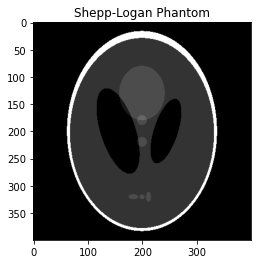

In [2]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [3]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = torch.tensor(image).to(device).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 400, 400])


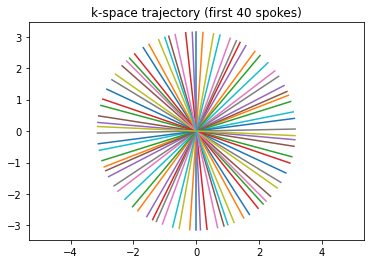

In [4]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [5]:
# convert k-space trajectory to a tensor
ktraj = torch.tensor(ktraj).to(device)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([2, 324000])


In [6]:
# create NUFFT objects, use 'ortho' for orthogonal FFTs
nufft_ob = tkbn.KbNufft(
    im_size=im_size,
    grid_size=grid_size,
).to(image)
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=im_size,
    grid_size=grid_size,
).to(image)

print(nufft_ob)
print(adjnufft_ob)


KbNufft
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)


KbNufftAdjoint
----------------------------------------
buffers
	tensor: table_0, shape: (6145,)
	tensor: table_1, shape: (6145,)
	tensor: im_size, shape: (2,)
	tensor: grid_size, shape: (2,)
	tensor: n_shift, shape: (2,)
	tensor: numpoints, shape: (2,)
	tensor: offsets, shape: (36, 2)
	tensor: table_oversamp, shape: (2,)
	tensor: order, shape: (2,)
	tensor: alpha, shape: (2,)
	tensor: scaling_coef, shape: (400, 400)



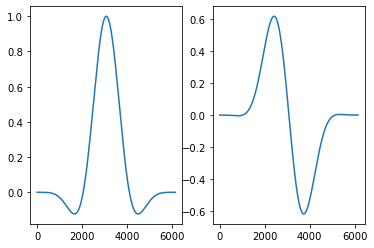

In [7]:
# plot the kernel
fig, axs = plt.subplots(1, 2)
axs.flat[0].plot(np.real(nufft_ob.table_0.cpu().numpy()))
axs.flat[1].plot(np.imag(nufft_ob.table_0.cpu().numpy()))
    
plt.show()

In [8]:
# calculate k-space data
kdata = nufft_ob(image, ktraj)
# add some noise (robustness test)
siglevel = torch.abs(kdata).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape).to(kdata)

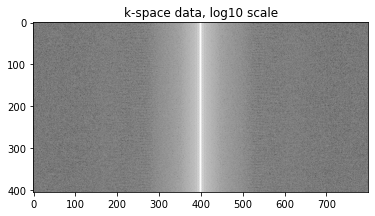

In [9]:
# plot the k-space data on log-scale
kdata_numpy = np.reshape(kdata.cpu().numpy(), (nspokes, spokelength))
plt.imshow(np.log10(np.absolute(kdata_numpy)))
plt.gray()
plt.title('k-space data, log10 scale')
plt.show()

In [10]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj)

# method 2: use density compensation
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=im_size)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

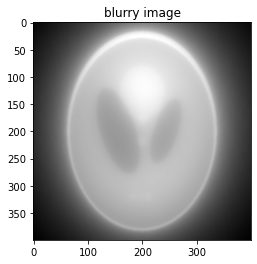

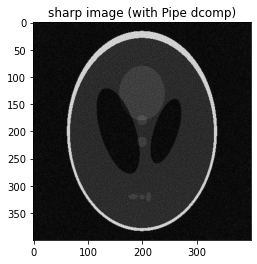

In [11]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.cpu().numpy())

image_sharp_numpy = np.squeeze(image_sharp.cpu().numpy())

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.title('blurry image')

plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with Pipe dcomp)')

plt.show()